Data Overview:
                          media_source  installs    revenue     spend    cac  \
week                                                                           
2024-12-30 00:00:00-05:00     Facebook      1628   86597.48  25056.73  15.39   
2024-12-30 00:00:00-05:00       Google      5229  127591.22  55476.31  10.61   
2024-12-30 00:00:00-05:00      organic      1201   79850.77       NaN    NaN   
2024-12-30 00:00:00-05:00      Twitter      1320   36926.01  14103.32  10.68   
2024-12-30 00:00:00-05:00      YouTube      1470   39932.53  12659.55   8.61   

                             roas  
week                               
2024-12-30 00:00:00-05:00  3.4561  
2024-12-30 00:00:00-05:00  2.2999  
2024-12-30 00:00:00-05:00     NaN  
2024-12-30 00:00:00-05:00  2.6182  
2024-12-30 00:00:00-05:00  3.1543  

Missing Values:
media_source    0
installs        0
revenue         0
spend           9
cac             9
roas            9
dtype: int64

Performance by Channel:
         

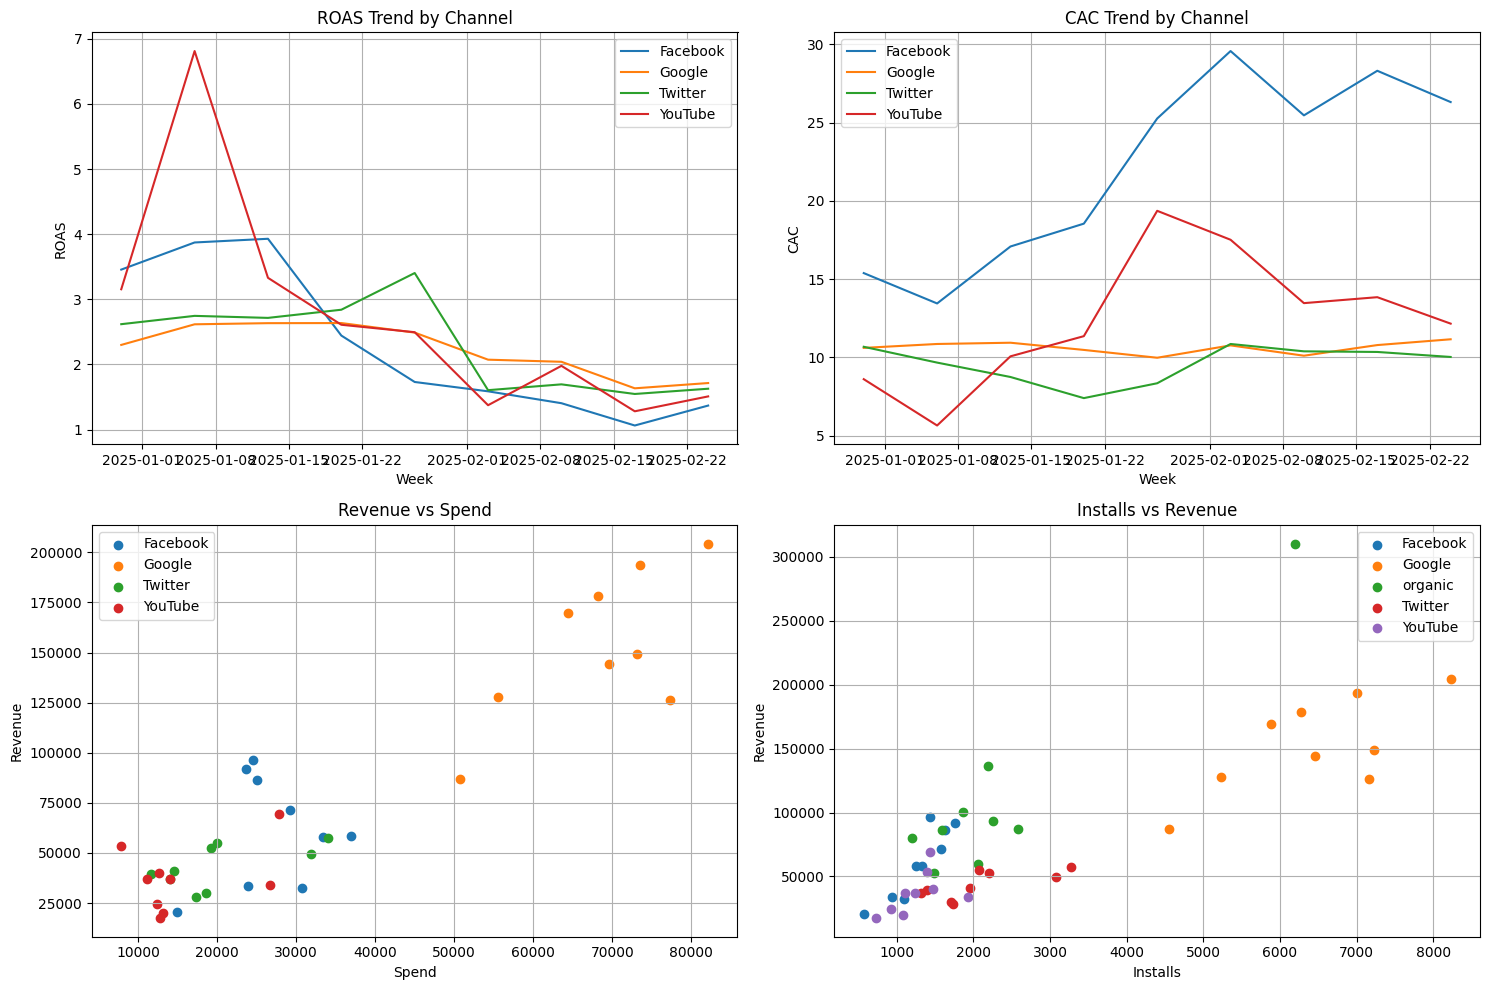


ROAS Forecast for Next Week:
Facebook: 1.5923
Google: 1.6983
Twitter: 1.6334
YouTube: 1.3969

Budget Allocation Recommendations:
Based on the analysis and forecasts, here are recommendations:
- YouTube: Forecast ROAS 1.40 - Recommend maintain/reduce budget
- Twitter: Forecast ROAS 1.63 - Recommend maintain/reduce budget
- Google: Forecast ROAS 1.70 - Recommend maintain/reduce budget
- Facebook: Forecast ROAS 1.59 - Recommend maintain/reduce budget


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Load the data
data = pd.read_csv('attribution_modeling_202505261625.csv')

# Convert week to datetime and set as index
data['week'] = pd.to_datetime(data['week'])
data.set_index('week', inplace=True)

# Data Exploration and Analysis
print("Data Overview:")
print(data.head())
print("\nMissing Values:")
print(data.isnull().sum())

# Calculate summary statistics
summary_stats = data.groupby('media_source').agg({
    'installs': ['mean', 'sum'],
    'revenue': ['mean', 'sum'],
    'spend': ['mean', 'sum'],
    'cac': ['mean'],
    'roas': ['mean']
})

print("\nPerformance by Channel:")
print(summary_stats)

# Visualization
plt.figure(figsize=(15, 10))

# ROAS Trend by Channel
plt.subplot(2, 2, 1)
for source in data['media_source'].unique():
    if source != 'organic':  # Skip organic as it has no spend/ROAS
        source_data = data[data['media_source'] == source]
        plt.plot(source_data.index, source_data['roas'], label=source)
plt.title('ROAS Trend by Channel')
plt.xlabel('Week')
plt.ylabel('ROAS')
plt.legend()
plt.grid(True)

# CAC Trend by Channel
plt.subplot(2, 2, 2)
for source in data['media_source'].unique():
    if source != 'organic':  # Skip organic as it has no spend/CAC
        source_data = data[data['media_source'] == source]
        plt.plot(source_data.index, source_data['cac'], label=source)
plt.title('CAC Trend by Channel')
plt.xlabel('Week')
plt.ylabel('CAC')
plt.legend()
plt.grid(True)

# Revenue vs Spend
plt.subplot(2, 2, 3)
for source in data['media_source'].unique():
    if source != 'organic':
        source_data = data[data['media_source'] == source]
        plt.scatter(source_data['spend'], source_data['revenue'], label=source)
plt.title('Revenue vs Spend')
plt.xlabel('Spend')
plt.ylabel('Revenue')
plt.legend()
plt.grid(True)

# Install vs Revenue
plt.subplot(2, 2, 4)
for source in data['media_source'].unique():
    source_data = data[data['media_source'] == source]
    plt.scatter(source_data['installs'], source_data['revenue'], label=source)
plt.title('Installs vs Revenue')
plt.xlabel('Installs')
plt.ylabel('Revenue')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# ROAS Forecasting
def forecast_roas(data, source, model_type='arima'):
    """Forecast ROAS for a given media source"""
    source_data = data[data['media_source'] == source].copy()

    if len(source_data) < 3:  # Need at least 3 points for meaningful forecast
        return None

    if model_type == 'arima':
        # ARIMA model
        try:
            model = ARIMA(source_data['roas'], order=(1, 1, 1))
            model_fit = model.fit()
            forecast = model_fit.forecast(steps=1)
            return forecast.values[0]
        except:
            return None
    elif model_type == 'random_forest':
        # Random Forest model with lag features
        try:
            # Create lag features
            for lag in [1, 2]:
                source_data[f'roas_lag_{lag}'] = source_data['roas'].shift(lag)
                source_data[f'cac_lag_{lag}'] = source_data['cac'].shift(lag)

            source_data.dropna(inplace=True)

            if len(source_data) < 3:
                return None

            X = source_data[['roas_lag_1', 'roas_lag_2', 'cac_lag_1', 'cac_lag_2']]
            y = source_data['roas']

            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

            model = RandomForestRegressor(n_estimators=100, random_state=42)
            model.fit(X_train, y_train)

            # Prepare last known values for prediction
            last_values = source_data.iloc[-1][['roas_lag_1', 'roas_lag_2', 'cac_lag_1', 'cac_lag_2']]
            last_values = pd.DataFrame([last_values], columns=X.columns)

            forecast = model.predict(last_values)
            return forecast[0]
        except:
            return None

# Forecast ROAS for each paid channel
paid_sources = [source for source in data['media_source'].unique() if source != 'organic']
forecasts = {}

for source in paid_sources:
    # Try ARIMA first
    forecast = forecast_roas(data, source, 'arima')

    # If ARIMA fails, try Random Forest
    if forecast is None:
        forecast = forecast_roas(data, source, 'random_forest')

    forecasts[source] = forecast

print("\nROAS Forecast for Next Week:")
for source, forecast in forecasts.items():
    if forecast is not None:
        print(f"{source}: {forecast:.4f}")
    else:
        print(f"{source}: Not enough data for reliable forecast")

# Budget Allocation Recommendation
print("\nBudget Allocation Recommendations:")
print("Based on the analysis and forecasts, here are recommendations:")

# Calculate efficiency metrics
paid_data = data[data['media_source'] != 'organic'].copy()
paid_data['efficiency'] = paid_data['roas'] / paid_data['cac']

# Get average efficiency by channel
efficiency = paid_data.groupby('media_source')['efficiency'].mean().sort_values(ascending=False)

for channel in efficiency.index:
    current_roas = paid_data[paid_data['media_source'] == channel]['roas'].iloc[-1]
    forecast_roas = forecasts.get(channel, current_roas)

    if forecast_roas is not None:
        recommendation = "increase" if forecast_roas > 2 else "maintain/reduce"
        print(f"- {channel}: Forecast ROAS {forecast_roas:.2f} - Recommend {recommendation} budget")
    else:
        print(f"- {channel}: Insufficient data - Recommend maintain current budget")

**<H1>Insights from Forecast:**

<H4>Google shows strong and growing ROAS — increase budget here

<H4>YouTube and Facebook have low or dropping ROAS — consider reducing spend

<H4>Twitter has moderate but improving ROAS — monitor closely

**<H1>Recommendation:**

"Next week, the marketing team should allocate more budget to Google, where return on ad spend is trending upward. Reduce or pause spending on low-performing channels like YouTube. Keep an eye on Twitter for future potential."